In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter, AutoMinorLocator

In [2]:
from matplotlib import rcParams
font_size = 17
rcParams['axes.titlesize'] = font_size - 1
rcParams['axes.titleweight'] = 'bold'
rcParams['axes.labelsize'] = font_size - 2
rcParams['xtick.labelsize'] = font_size - 2
rcParams['ytick.labelsize'] = font_size - 2
rcParams['legend.fontsize'] = font_size
rcParams['figure.titlesize'] = font_size 
rcParams['figure.titleweight'] = 'bold'

## Read Climate TRACE data

In [3]:
data_dir = '../data/ClimateTrace/waste/'
df = pd.read_csv(data_dir+'solid-waste-disposal_emissions_sources.csv')

# select ch4 and use newest data
df = df[(df['gas']=='ch4')].sort_values(['source_id', 'start_time']).drop_duplicates(subset='source_id', keep='last')

# add lon lat columns
df[['lon', 'lat']] = df['geometry_ref'].str.split('_', expand=True).rename(columns={1:'lon', 2:'lat'})[['lon', 'lat']]

# rename columns
df.rename(columns={'other1': 'metadata_source', 'other4': 'emissions_estimation_method',
                          'other5': 'metadata_reported_year',  'other6': 'operating_status'},
                          inplace=True)

/var/folders/n2/jdncdjcx465bv0ls_nyvsqx40000gn/T/ipykernel_44924/813328699.py:2: DtypeWarning: Columns (25,33,35) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_dir+'solid-waste-disposal_emissions_sources.csv')


## Read HSI summary data

In [4]:
ds_hsi = pd.read_csv('../data/landfills_hyper_summary.csv')
emission_landfill = ds_hsi.groupby(['country', 'name'], as_index=False).agg({'emission':'mean'})['emission']

In [5]:
ds_hsi['country'].drop_duplicates().reset_index(drop=True)

0         Argentina
1        Bangladesh
2            Brazil
3             China
4             India
5              Iran
6            Israel
7            Jordan
8            Kuwait
9            Mexico
10         Pakistan
11     Saudi Arabia
12            Spain
13          Tunisia
14    United States
15       Uzbekistan
16            Yemen
Name: country, dtype: object

In [6]:
iso3_country_dict = {'Argentina': 'ARG', 'Bangladesh': 'BGD', 'Brazil': 'BRA',
                     'China': 'CHN', 'India': 'IND', 'Iran': 'IRN', 'Jordan': 'JOR', 'Israel': 'ISR',
                     'Jordan': 'JOR', 'Kuwait': 'KWT', 'Mexico': 'MEX', 'Pakistan': 'PAK',
                     'Saudi Arabia': 'SAU', 'Spain': 'ESP', 'Tunisia': 'TUN', 'United States': 'USA',
                     'Uzbekistan': 'UZB', 'Yemen': 'YEM'}

def sum_country(iso3_country):
    df_country = df[df['iso3_country']==iso3_country_dict[iso3_country]][['source_id', 'emissions_quantity']]
    print('##', iso3_country, '\n', len(df_country), 'landfills, total site-level emission (t/yr):', df_country['emissions_quantity'].sum())
    print('HSI', len(ds_hsi[ds_hsi['country']==iso3_country].drop_duplicates('name')))
    print('HSI/CT (%)', np.round(len(ds_hsi[ds_hsi['country']==iso3_country].drop_duplicates('name'))/len(df_country)*100, 1))


In [7]:
for iso3_country in iso3_country_dict.keys():
    sum_country(iso3_country)

## Argentina 
 71 landfills, total site-level emission (t/yr): 528082.1
HSI 3
HSI/CT (%) 4.2
## Bangladesh 
 1 landfills, total site-level emission (t/yr): 13506.95
HSI 1
HSI/CT (%) 100.0
## Brazil 
 285 landfills, total site-level emission (t/yr): 1798209.4300000002
HSI 2
HSI/CT (%) 0.7
## China 
 592 landfills, total site-level emission (t/yr): 2026552.48
HSI 1
HSI/CT (%) 0.2
## India 
 534 landfills, total site-level emission (t/yr): 954117.74
HSI 10
HSI/CT (%) 1.9
## Iran 
 42 landfills, total site-level emission (t/yr): 363337.58999999997
HSI 2
HSI/CT (%) 4.8
## Jordan 
 5 landfills, total site-level emission (t/yr): 107598.01000000001
HSI 2
HSI/CT (%) 40.0
## Israel 
 2 landfills, total site-level emission (t/yr): 23597.53
HSI 2
HSI/CT (%) 100.0
## Kuwait 
 9 landfills, total site-level emission (t/yr): 123317.54000000001
HSI 1
HSI/CT (%) 11.1
## Mexico 
 2158 landfills, total site-level emission (t/yr): 4175244.63
HSI 5
HSI/CT (%) 0.2
## Pakistan 
 2 landfills, total site-level 

In [8]:
def plot_cdf(data, ax, twinaxis='log'):
    # Fig 5 of https://www.pnas.org/doi/full/10.1073/pnas.1605617113

    # Step 1: Sort the emission data in descending order
    sorted_data = np.sort(data)[::-1]

    # Step 2: Calculate the cumulative sum of the sorted data
    cumulative_sum = np.cumsum(sorted_data)

    # Step 3: Calculate the percentile values for the emission data
    percentiles = np.linspace(0, 100, len(sorted_data))

    # Step 4: Plot the CDF of the summed fluxes against the flux percentiles
    ax.plot(percentiles, cumulative_sum / np.sum(sorted_data), '-', c='k')#, label='CDF')
    # ax.set_xlabel('Percentile (%) of Plumes (High to Low)')
    # ax.set_ylabel('Total Emission Pcercentage')
    # ax.axhline(y=0.6, c='darkgray', linestyle='--')
    # ax.hlines(y=0.4, xmin=0, xmax=15, color='darkgray', linestyle='--')

    # Step 5: Plot the emission at the respective percentiles as a red line
    ax2 = ax.twinx()
    if twinaxis == 'log':
        ax2.set_yscale('log')
        ax2.set_ylabel('Emission Rate (t h$^{-1}$)', c='C0')
    ax2.set_yscale('log')
    ax2.plot(percentiles, sorted_data, '-', c='C0')#, label='Emission Rates')
    ax2.tick_params(axis='y', colors='C0')

    # ax2.hlines(y=7, xmin=0.1, xmax=100, color='darkgray', linestyle='--')
    # ax2.hlines(y=.5, xmin=0.1, xmax=100, color='darkgray', linestyle='--')
    # ax2.text(102, 9, 9, c='gray', size=font_size-2)

    return ax2

/var/folders/n2/jdncdjcx465bv0ls_nyvsqx40000gn/T/ipykernel_44924/845067961.py:27: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax.set_xlim(xmin=0, xmax=100)
/Users/xinz/miniconda3/envs/hyperch4/lib/python3.11/site-packages/matplotlib/scale.py:255: RuntimeWarning: overflow encountered in power
  return np.power(self.base, values)


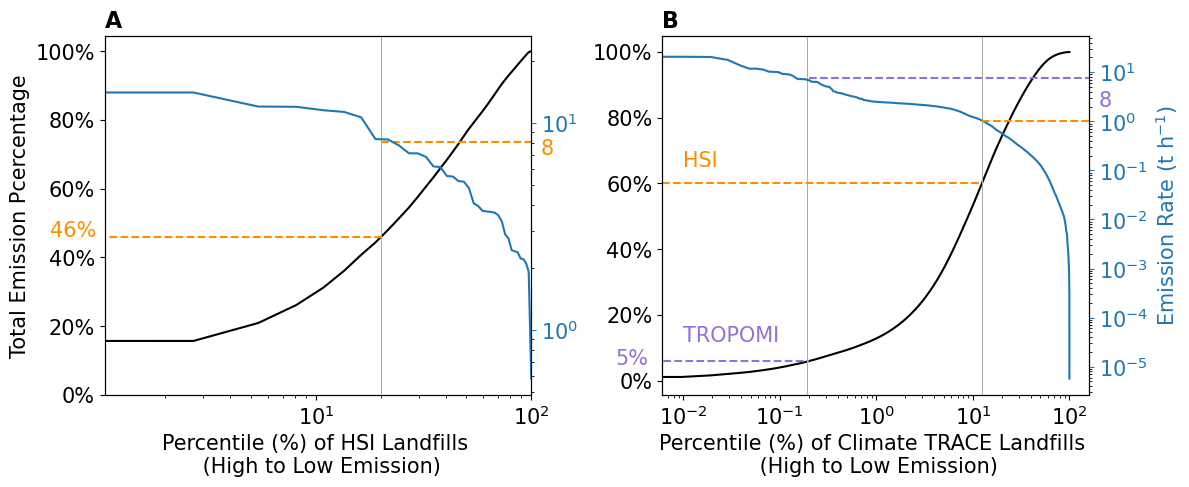

In [9]:
fig, axs = plt.subplots(ncols=2, figsize=(12, 5))

axs = axs.flatten()

for ax in axs:
    ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))

# ----------- HSI -----------
ax = axs[0]
ax.set_xscale('log')

plot_cdf(emission_landfill, ax, twinaxis=None)

ax.set_xlabel('Percentile (%) of HSI Landfills \n (High to Low Emission)')
ax.set_ylabel('Total Emission Pcercentage')
# ax.axhline(y=0.70, c='darkorange', linestyle='--')
ax.axvline(x=20, c='darkgray', linestyle='-', linewidth=0.7)
ax.hlines(y=.735, xmin=20, xmax=100, color='darkorange', linestyle='--')  # 8 t/h
ax.hlines(y=.46, xmin=.01, xmax=20, color='darkorange', linestyle='--')

ax.text(0.58, 0.46, '46%', c='darkorange', size=font_size-2)
plt.text(110, 7, 8, c='darkorange', size=font_size-2)

# ax.xaxis.set_minor_locator(AutoMinorLocator(4))

ax.set_ylim(ymin=0)
ax.set_xlim(xmin=0, xmax=100)


# ----------- Climate TRACE -----------
ax = axs[1]
# t/yr
ax2 = plot_cdf(df['emissions_quantity']/365/24, ax)

ax.set_xlabel('Percentile (%) of Climate TRACE Landfills \n (High to Low Emission)')
ax.set_ylabel('')
ax.set_xscale('log')

# TROPOMI detection limit
ax.text(.01, .12, 'TROPOMI', c='mediumpurple', size=font_size-2)
ax.hlines(y=0.06, xmin=1e-3, xmax=0.2, color='mediumpurple', linestyle='--')
ax.hlines(y=0.92, xmin=0.2, xmax=1e3, color='mediumpurple', linestyle='--')
plt.text(200, 2, 8, c='mediumpurple', size=font_size-2)
ax.text(.002, .05, '5%', c='mediumpurple', size=font_size-2)

# HSI detection limit
ax.text(.01, .65, 'HSI', c='darkorange', size=font_size-2)
ax.axvline(x=12.5, c='darkgray', linestyle='-', linewidth=0.7)
ax.axhline(y=0.6, xmin=0, xmax=0.75, c='darkorange', linestyle='--')
ax2.axhline(y=1, xmin=0.75, xmax=1e3, c='darkorange', linestyle='--')
# plt.text(200, .2, .5, c='darkorange', size=font_size-2)
# ax.text(.0015, .65, '60%', c='darkorange', size=font_size-2)

# vertical line
ax.axvline(x=0.19, c='darkgray', linestyle='-', linewidth=0.7)

axs[0].set_title('A', x=0.02, y=1.1, pad=-20)
axs[1].set_title('B', x=0.02, y=1.1, pad=-20)


fig.tight_layout()
fig.savefig('../figures/emission_cdf.pdf')

In [10]:
len(df)

10314

In [11]:
# number of landfills emission rate > 8 t/h
df[df['emissions_quantity']/365/24 >= 8]

,source_id,source_name,source_type,iso3_country,sector,subsector,start_time,end_time,lat,lon,...,other7,other7_def,other8,other8_def,other9,other9_def,other10,other10_def,created_date,modified_date
4475,25770989,Bandeirantes,Sanitary Landfills,BRA,waste,solid-waste-disposal,2022-01-01 00:00:00,2022-12-31 00:00:00,-23.42216056,-46.75544142,...,NaN,landfill_gas_collection_system_present,NaN,landfill_cover_type,2000000.0,original_reported_annual_incoming_waste,30000000.0,original_reported_waste_in_place,2023-11-08 00:00:00,NaN
102715,25772102,Bisasar,Sanitary Landfills,ZAF,waste,solid-waste-disposal,2022-01-01 00:00:00,2022-12-31 00:00:00,-29.8167703149,30.978784561157,...,NaN,landfill_gas_collection_system_present,NaN,landfill_cover_type,1260000.0,original_reported_annual_incoming_waste,15200000.0,original_reported_waste_in_place,2023-11-08 00:00:00,NaN
23695,25772273,Fyli Landfill,Sanitary Landfills,GRC,waste,solid-waste-disposal,2022-01-01 00:00:00,2022-12-31 00:00:00,38.0743455110176,23.6507749557495,...,NaN,landfill_gas_collection_system_present,NaN,landfill_cover_type,1700000.0,original_reported_annual_incoming_waste,8500000.0,original_reported_waste_in_place,2023-11-08 00:00:00,NaN
72515,25772323,Komurcuoda,Sanitary Landfills,TUR,waste,solid-waste-disposal,2022-01-01 00:00:00,2022-12-31 00:00:00,41.1450849,29.3707466,...,NaN,landfill_gas_collection_system_present,NaN,landfill_cover_type,1825000.0,original_reported_annual_incoming_waste,21000000.0,original_reported_waste_in_place,2023-11-08 00:00:00,NaN
61885,25772368,Legajny,Sanitary Landfills,POL,waste,solid-waste-disposal,2022-01-01 00:00:00,2022-12-31 00:00:00,53.81717293,20.625844,...,NaN,landfill_gas_collection_system_present,NaN,landfill_cover_type,1600000.0,original_reported_annual_incoming_waste,1600000.0,original_reported_waste_in_place,2023-11-08 00:00:00,NaN
8535,25772378,Loma Los Colorados,Sanitary Landfills,CHL,waste,solid-waste-disposal,2022-01-01 00:00:00,2022-12-31 00:00:00,-32.9546645267949,-70.7979583740234,...,NaN,landfill_gas_collection_system_present,NaN,landfill_cover_type,2190000.0,original_reported_annual_incoming_waste,16300000.0,original_reported_waste_in_place,2023-11-08 00:00:00,NaN
48625,25772381,Los Laureles,NaN,MEX,waste,solid-waste-disposal,2022-01-01 00:00:00,2022-12-31 00:00:00,20.537576,-103.179987,...,1.0,landfill_gas_collection_system_present,NaN,landfill_cover_type,2244334.0,original_reported_annual_incoming_waste,NaN,original_reported_waste_in_place,2023-11-08 00:00:00,NaN
72605,25772406,Odayeri,Sanitary Landfills,TUR,waste,solid-waste-disposal,2022-01-01 00:00:00,2022-12-31 00:00:00,41.2161766,28.8581657,...,NaN,landfill_gas_collection_system_present,NaN,landfill_cover_type,4015000.0,original_reported_annual_incoming_waste,42000000.0,original_reported_waste_in_place,2023-11-08 00:00:00,NaN
52215,25772687,Relleno Sanitario Portezuelos,NaN,MEX,waste,solid-waste-disposal,2022-01-01 00:00:00,2022-12-31 00:00:00,32.41319444,-116.7424167,...,1.0,landfill_gas_collection_system_present,NaN,landfill_cover_type,1579160.0,original_reported_annual_incoming_waste,NaN,original_reported_waste_in_place,2023-11-08 00:00:00,NaN
53225,25772852,Sistema Integral Para El Manejo Ecologico Y Pr...,NaN,MEX,waste,solid-waste-disposal,2022-01-01 00:00:00,2022-12-31 00:00:00,25.84980283,-100.2959838,...,1.0,landfill_gas_collection_system_present,NaN,landfill_cover_type,3409500.0,original_reported_annual_incoming_waste,NaN,original_reported_waste_in_place,2023-11-08 00:00:00,NaN


In [12]:
# total landfill emissions from ClimateTRACE
df['emissions_quantity'].sum()/1e6  # t/yr --> Tg/yr

36.7509102

In [13]:
print('Total Climate TRACE landfill numbers: ', len(df))

Total Climate TRACE landfill numbers:  10314


In [14]:
df_top20 = df.sort_values('emissions_quantity',ascending = False)[:20]
df_top20.to_csv('../data/ClimateTrace/waste/top20.csv', index=False)